# VAE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE

## 学習データ作成

In [2]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 1000, 256, 1)


(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (1000, 256, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


## モデル作成

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean = torch.mean(x, (0, 2, 3), keepdim=True)
        std = torch.std(x, (0, 2, 3), keepdim=True)
        x_normalized = (x - mean) / (std**2 + self.epsilon)**0.5
        return self.gamma * x_normalized + self.beta

## モデル作成

## モデル学習

In [4]:
#netよう
z_dim = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = modelVAE.VAE_cnn_drop_net(z_dim, device).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
input_data = torch.from_numpy(data.astype(np.float32)).clone()
input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()

model.train()
loss_list = []
cnt = 0
for epoch in input_data:
    losses = []
    cnt += 1
    for x in epoch:
        x = x.to(device) # データをGPUにのせる
        loss, z, y = model(x, device) # 損失関数の値 loss 、潜在ベクトル z 、再構築画像 y を出力
        model.zero_grad() # モデルの勾配を初期化
        loss.backward() # モデル内のパラメータの勾配を計算
        optimizer.step() # 最適化を実行
        losses.append(loss.cpu().detach().numpy()) # ミニバッチの損失を記録
    loss_list.append(np.average(losses)) # バッチ全体の損失を登録
    print("EPOCH: {} loss: {}".format(cnt, np.average(losses)))
    # for x in input_test_data:
    #     KL_loss, reconstruction_loss = model.loss(x)
    #     loss = KL_loss + reconstruction_loss
    #     losses_val.append(loss.cpu().detach().numpy())

    # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
    #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

EPOCH: 1 loss: 185.2886505126953
EPOCH: 2 loss: 124.69698333740234
EPOCH: 3 loss: 100.24903869628906
EPOCH: 4 loss: 90.36830139160156
EPOCH: 5 loss: 86.86665344238281
EPOCH: 6 loss: 85.14701843261719
EPOCH: 7 loss: 81.88748168945312
EPOCH: 8 loss: 80.76409912109375
EPOCH: 9 loss: 82.08612823486328
EPOCH: 10 loss: 81.85626220703125
EPOCH: 11 loss: 79.59439086914062
EPOCH: 12 loss: 81.97114562988281
EPOCH: 13 loss: 82.29426574707031
EPOCH: 14 loss: 82.63147735595703
EPOCH: 15 loss: 73.591064453125
EPOCH: 16 loss: 84.99635314941406
EPOCH: 17 loss: 80.73226165771484
EPOCH: 18 loss: 78.75169372558594
EPOCH: 19 loss: 76.56515502929688
EPOCH: 20 loss: 85.2327651977539
EPOCH: 21 loss: 78.5687255859375
EPOCH: 22 loss: 83.0224609375
EPOCH: 23 loss: 79.56979370117188
EPOCH: 24 loss: 79.2899398803711
EPOCH: 25 loss: 84.30046081542969
EPOCH: 26 loss: 77.44579315185547
EPOCH: 27 loss: 80.4991226196289
EPOCH: 28 loss: 77.32754516601562
EPOCH: 29 loss: 81.71175384521484
EPOCH: 30 loss: 80.485260009765

In [5]:
# z_dim = 8
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = modelVAE.VAE_cnn(z_dim, device).to(device)
# # optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
# input_data = torch.from_numpy(data.astype(np.float32)).clone()
# input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()
# for epoch in input_data:
#     losses = []
#     KL_losses = []
#     reconstruction_losses = []
#     model.train()
#     for x in epoch:
#         x = x.to(device)
#         model.zero_grad()
#         KL_loss, reconstruction_loss = model.loss(x)  # lossの各項の計算
#         loss = KL_loss + reconstruction_loss  # 和を取ってlossとする
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.detach().numpy())
#         KL_losses.append(KL_loss.detach().numpy())
#         reconstruction_losses.append(reconstruction_loss.detach().numpy())

#     losses_val = []
#     model.eval()
#     # for x in input_test_data:
#     #     KL_loss, reconstruction_loss = model.loss(x)
#     #     loss = KL_loss + reconstruction_loss
#     #     losses_val.append(loss.cpu().detach().numpy())

#     # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
#     #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

## モデルの保存

In [6]:
# model_name = "vaemodel"
# ModelEdit = mainmodel.Modeledit("syuron")
# ModelEdit.save_model(model, model_name) 

## 確認だよーん

tensor([[[0.1050, 0.0664, 0.0670, 0.0676, 0.0714, 0.0725, 0.0778, 0.0784,
          0.0790, 0.0725, 0.0709, 0.0680, 0.0686, 0.0692, 0.0749, 0.0766,
          0.0835, 0.0841, 0.0847, 0.0805, 0.0795, 0.0782, 0.0787, 0.0794,
          0.0983, 0.1041, 0.1250, 0.1255, 0.1260, 0.1247, 0.1245, 0.1250,
          0.1255, 0.1260, 0.1247, 0.1245, 0.1250, 0.1255, 0.1260, 0.1247,
          0.1245, 0.1250, 0.1255, 0.1260, 0.1247, 0.1245, 0.1250, 0.1255,
          0.1260, 0.1247, 0.1245, 0.1250, 0.1255, 0.1260, 0.1247, 0.1245,
          0.1250, 0.1255, 0.1260, 0.1247, 0.1245, 0.1250, 0.1255, 0.1260,
          0.1247, 0.1245, 0.1250, 0.1255, 0.1260, 0.1247, 0.1245, 0.1250,
          0.1255, 0.1260, 0.1247, 0.1245, 0.1250, 0.1255, 0.1260, 0.1247,
          0.1245, 0.1250, 0.1255, 0.1260, 0.1247, 0.1245, 0.1250, 0.1255,
          0.1260, 0.1247, 0.1245, 0.1250, 0.1255, 0.1260, 0.1247, 0.1245,
          0.1250, 0.1255, 0.1260, 0.1247, 0.1245, 0.1250, 0.1255, 0.1260,
          0.1247, 0.1245, 0.1250, 0.12

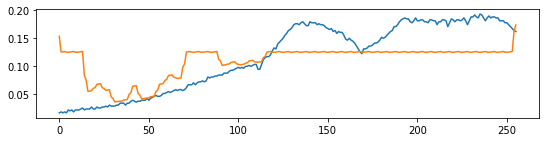

normal:9.883849326521158


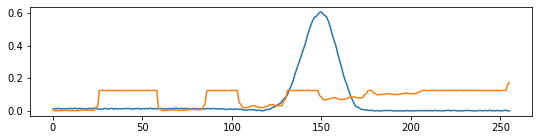

anomarly:26.876582864206284
anomaly
<class 'torch.Tensor'>


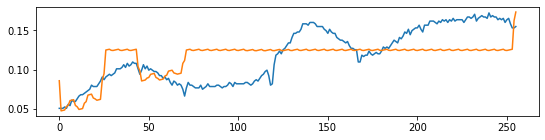

normal:6.410258132964373


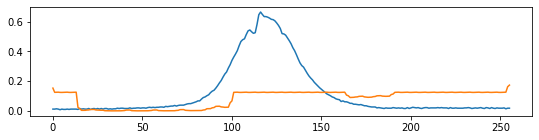

anomarly:31.117303285747766
anomaly
<class 'torch.Tensor'>


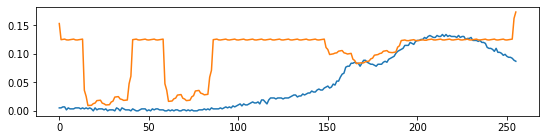

normal:13.531476899981499
anomaly


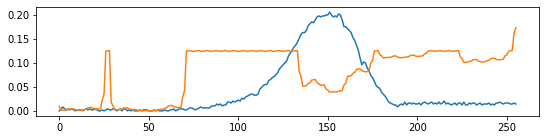

anomarly:18.237029108480783
anomaly
<class 'torch.Tensor'>


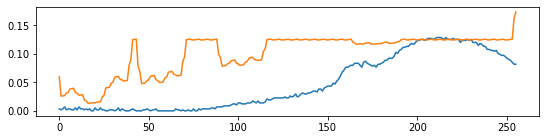

normal:13.534375797957182
anomaly


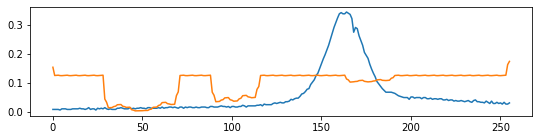

anomarly:19.34621722670272
anomaly
<class 'torch.Tensor'>


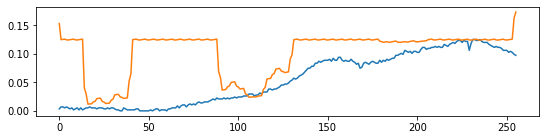

normal:12.004382739309222
anomaly


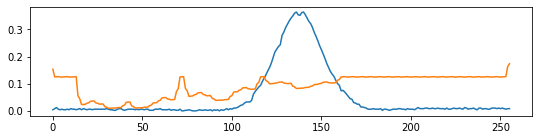

anomarly:22.630463394336402
anomaly


IndexError: index 50 is out of bounds for axis 0 with size 50

In [7]:
# num = 5
data0 =  torch.from_numpy((test_data[0]).astype(np.float32)).clone()
data0 = data0[np.newaxis, np.newaxis, :]
loss, z, recon = model(data0, device)
# recon, _ = model(data0)
recon = recon.detach()
print(recon)

for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        print(type(data0))
        plt.figure(figsize=(9, 2))
        # data = data0.numpy()
        input_data = data0[np.newaxis, np.newaxis, :]
        # recon,_ = model(input_data)
        loss, z, recon = model(input_data, device)
        recon = recon.detach().numpy()
        plt.plot(data0.numpy())
        plt.plot(recon.flatten())
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
        print("normal:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")
            
        plt.figure(figsize=(9, 2))
        # data = test0.numpy()
        input_data = test0[np.newaxis, np.newaxis, :]
        # recon,_ = model(input_data)
        loss, z, recon = model(input_data, device)
        recon = recon.detach().numpy()
        plt.plot(test0.numpy(),label="testdata")
        plt.plot(recon.flatten(),label="recondata")
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
        print("anomarly:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols=5, figsize=(20,12))
model.eval()
for r in range(3):
    for c in range(5):
        ax[r,c].imshow(model.decoder(torch.randn(10).cuda()).detach().cpu().numpy().reshape(28,28), cmap="gray")
        ax[r,c].axis("off")